# 02. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs) 
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


## Creating data to view and fit

We could start by importing a classification dataset but let's practice making some of our own classification data.

> 🔑 **Note:** It's a common practice to get you and model you build working on a toy (or simple) dataset before moving to your actual problem. Treat it as a rehersal experiment before the actual experiment(s).

Since classification is predicting whether something is one thing or another, let's make some data to reflect that.

To do so, we'll use Scikit-Learn's [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function.



In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Make circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [3]:
# Check out the features
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [4]:
# See the first 10 labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

Okay, we've seen some of our data and labels, how about we move towards visualizing?

> 🔑 **Note:** One important step of starting any kind of machine learning project is to [become one with the data](https://karpathy.github.io/2019/04/25/recipe/). And one of the best ways to do this is to visualize the data you're working with as much as possible. The data explorer's motto is "visualize, visualize, visualize".

We'll start with a DataFrame.

In [5]:
# Make dataframe of features and labels
import pandas as pd

circles = pd.DataFrame({"X0" : X[:, 0], "X1" : X[:, 1], "label" : y})
circles

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [6]:
# Check out the different labels
circles.label.value_counts()

0    500
1    500
Name: label, dtype: int64

Alright, looks like we're dealing with a **binary classification** problem. It's binary because there are only two labels (0 or 1).

If there were more label options (e.g. 0, 1, 2, 3 or 4), it would be called **multiclass classification**.

Let's take our visualization a step further and plot our data.

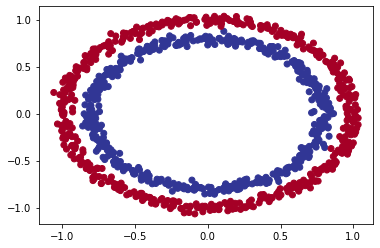

In [7]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

> 🛠 **Practice:** Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train. I think you'll find the data very similar to what we've just created.

## Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input `X` and get our model to predict `y`.

So let's check out the shapes of `X` and `y`.

In [8]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

Hmm, where do these numbers come from?

In [9]:
# Check how many samples we have
len(X), len(y)

(1000, 1000)

In [10]:
# View the first example of feature and label
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`). 

Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [11]:
# set random seed
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential([
    
    tf.keras.layers.Dense(1)
])

# Compile a model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(),
                metrics = ['accuracy'])

# Fit a model
model_1.fit(X, y, epochs = 5)

Epoch 1/5
32/32 [==============================] - 0s 6ms/step - loss: 2.8544 - accuracy: 0.4600
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 0.7131 - accuracy: 0.5430
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5090
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5010
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.4820


Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [12]:
# Train our model for longer (more chances to look at the data)
model_1.fit(X, y, epochs=200, verbose=2) # set verbose=0 to remove training updates
model_1.evaluate(X, y)

Epoch 1/200
32/32 - 0s - loss: 0.6945 - accuracy: 0.4900
Epoch 2/200
32/32 - 0s - loss: 0.6942 - accuracy: 0.4960
Epoch 3/200
32/32 - 0s - loss: 0.6947 - accuracy: 0.4470
Epoch 4/200
32/32 - 0s - loss: 0.6941 - accuracy: 0.4880
Epoch 5/200
32/32 - 0s - loss: 0.6940 - accuracy: 0.4800
Epoch 6/200
32/32 - 0s - loss: 0.6936 - accuracy: 0.5050
Epoch 7/200
32/32 - 0s - loss: 0.6943 - accuracy: 0.4970
Epoch 8/200
32/32 - 0s - loss: 0.6941 - accuracy: 0.4800
Epoch 9/200
32/32 - 0s - loss: 0.6940 - accuracy: 0.4830
Epoch 10/200
32/32 - 0s - loss: 0.6938 - accuracy: 0.4790
Epoch 11/200
32/32 - 0s - loss: 0.6944 - accuracy: 0.4550
Epoch 12/200
32/32 - 0s - loss: 0.6945 - accuracy: 0.4760
Epoch 13/200
32/32 - 0s - loss: 0.6943 - accuracy: 0.4890
Epoch 14/200
32/32 - 0s - loss: 0.6944 - accuracy: 0.5030
Epoch 15/200
32/32 - 0s - loss: 0.6941 - accuracy: 0.4490
Epoch 16/200
32/32 - 0s - loss: 0.6944 - accuracy: 0.4890
Epoch 17/200
32/32 - 0s - loss: 0.6941 - accuracy: 0.4910
Epoch 18/200
32/32 - 0s

Epoch 142/200
32/32 - 0s - loss: 0.6941 - accuracy: 0.4790
Epoch 143/200
32/32 - 0s - loss: 0.6943 - accuracy: 0.4790
Epoch 144/200
32/32 - 0s - loss: 0.6943 - accuracy: 0.4650
Epoch 145/200
32/32 - 0s - loss: 0.6943 - accuracy: 0.4990
Epoch 146/200
32/32 - 0s - loss: 0.6945 - accuracy: 0.4570
Epoch 147/200
32/32 - 0s - loss: 0.6943 - accuracy: 0.5110
Epoch 148/200
32/32 - 0s - loss: 0.6943 - accuracy: 0.4880
Epoch 149/200
32/32 - 0s - loss: 0.6941 - accuracy: 0.4500
Epoch 150/200
32/32 - 0s - loss: 0.6943 - accuracy: 0.4700
Epoch 151/200
32/32 - 0s - loss: 0.6938 - accuracy: 0.4620
Epoch 152/200
32/32 - 0s - loss: 0.6940 - accuracy: 0.4990
Epoch 153/200
32/32 - 0s - loss: 0.6942 - accuracy: 0.4870
Epoch 154/200
32/32 - 0s - loss: 0.6936 - accuracy: 0.4810
Epoch 155/200
32/32 - 0s - loss: 0.6944 - accuracy: 0.4780
Epoch 156/200
32/32 - 0s - loss: 0.6944 - accuracy: 0.4680
Epoch 157/200
32/32 - 0s - loss: 0.6944 - accuracy: 0.4990
Epoch 158/200
32/32 - 0s - loss: 0.6940 - accuracy: 0.49

[0.6934829950332642, 0.5]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [13]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (same as model_1 but with an extra layer)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # add an extra layer
  tf.keras.layers.Dense(1) 
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0) # set verbose=0 to make the output print less

In [14]:
# Evaluate the model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5000


[0.6933314204216003, 0.5]

Still not even as good as guessing (~50% accuracy)... hmm...?

Let's remind ourselves of a couple more ways we can use to improve our models.

## Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function (such as the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, which is usually pretty good for many problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more epochs (leave it training for longer).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

How about we try adding more neurons, an extra layer and our friend the Adam optimizer?

Surely doing this will result in predictions better than guessing...

> **Note:** The following message (below this one) can be ignored if you're running TensorFlow 2.8.0+, the error seems to have been fixed.

> **Note:** If you're using TensorFlow 2.7.0+ (but not 2.8.0+) the original code from the following cells may have caused some errors. They've since been updated to fix those errors. You can see explanations on what happened at the following resources:
* [Example Colab Notebook](https://colab.research.google.com/drive/1_dlrB_DJOBS9c9foYJs49I0YwN7LTakl?usp=sharing)
* [TensorFlow for Deep Learning GitHub Discussion on TensorFlow 2.7.0 breaking changes](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278)


In [15]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
model_3 = tf.keras.Sequential([
  # Before TensorFlow 2.7.0
  # tf.keras.layers.Dense(100), # add 100 dense neurons

  # With TensorFlow 2.7.0
  # tf.keras.layers.Dense(100, input_shape=(None, 1)), # add 100 dense neurons

  ## After TensorFlow 2.8.0 ##
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=1) # fit for 100 passes of the data

Epoch 1/100
32/32 [==============================] - 0s 2ms/step - loss: 2.9658 - accuracy: 0.4490
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7229 - accuracy: 0.4390
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6971 - accuracy: 0.4700
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.4620
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.4750
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.4750
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.5040
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.4980
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.4880
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.4480
Epoch 11/

32/32 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.4480
Epoch 84/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.4970
Epoch 85/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.4590
Epoch 86/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7002 - accuracy: 0.4900
Epoch 87/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.4540
Epoch 88/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6981 - accuracy: 0.4590
Epoch 89/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6979 - accuracy: 0.4750
Epoch 90/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.4620
Epoch 91/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.4980
Epoch 92/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6988 - accuracy: 0.4760
Epoch 93/100


In [16]:
# Evaluate the model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5000


[0.6933314204216003, 0.5]

Still! 

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualizations to see what's happening.

> 🔑 **Note:** Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: **visualize, visualize, visualize**. Inspect your data, inspect your model, inpsect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features (`X`) and labels (`y`).
* Creates a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

If this sounds confusing, let's see it in code and then see the output.

> 🔑 **Note:** If you're ever unsure of what a function does, try unraveling it and writing it line by line for yourself to see what it does. Break it into small parts and see what each part outputs.

In [17]:
import numpy as np

In [18]:
# nx, ny = (3, 2)
# x = np.linspace(0, 1, nx)
# y = np.linspace(0, 1, ny)

In [19]:
# x

In [20]:
# y

In [21]:
# xv, yv = np.meshgrid(x, y)
# xv

In [22]:
# yv

In [23]:
def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary created by a model predicting on X.
    This function was inspired by two resources:
    1. https://cs231n.github.io/neural-networks-case-study/
    2. https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb 
    """
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
    # Create X value (we're going to make predictions on these)
    x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together

    # Make predictions
    y_pred = model.predict(x_in)

    # Check for multi-class
    if len(y_pred[0]) > 1:
        print("doing multiclass classification")
        # We have to reshape our prediction to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classification")
        y_pred = np.round(y_pred).reshape(xx.shape)
  
    # Plot the decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

doing binary classification


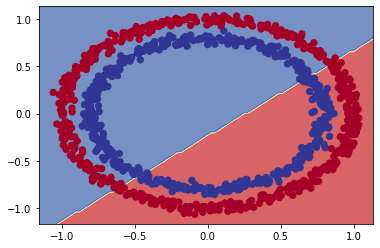

In [24]:
# Check out the predictions our model is making
plot_decision_boundary(model_3, X, y)

In [25]:
# Lecture - 10
# Set random seed
tf.random.set_seed(42)

# Create some regression data
X_regression = np.arange(0, 1000, 5)
y_regression = np.arange(100, 1100, 5)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

# Fit our model to the data
# Note: Before TensorFlow 2.7.0, this line would work
# model_3.fit(X_reg_train, y_reg_train, epochs=100)

# After TensorFlow 2.7.0, see here for more: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278
model_3.fit(tf.expand_dims(X_reg_train, axis=-1),y_reg_train,epochs=100)

Epoch 1/100


ValueError: in user code:

    E:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    E:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    E:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    E:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    E:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    E:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    E:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    E:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    E:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [None, 1]


Oh wait... we compiled our model for a binary classification problem.

No trouble, we can recreate it for a regression problem.

In [26]:
# Setup random seed
tf.random.set_seed(42)

# Recreate the model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Change the loss and metrics of our compiled model
model_3.compile(loss=tf.keras.losses.mae, # change the loss function to be regression-specific
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) # change the metric to be regression-specific

# Fit the recompiled model
model_3.fit(tf.expand_dims(X_reg_train, axis=-1), 
            y_reg_train, 
            epochs=100)

Epoch 1/100
5/5 [==============================] - 0s 1ms/step - loss: 248.2155 - mae: 248.2155
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 138.9005 - mae: 138.9005
Epoch 3/100
5/5 [==============================] - 0s 2ms/step - loss: 53.1039 - mae: 53.1039
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 73.5170 - mae: 73.5170
Epoch 5/100
5/5 [==============================] - 0s 2ms/step - loss: 71.2358 - mae: 71.2358
Epoch 6/100
5/5 [==============================] - 0s 1ms/step - loss: 47.0040 - mae: 47.0040
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 45.9386 - mae: 45.9386
Epoch 8/100
5/5 [==============================] - 0s 2ms/step - loss: 42.3638 - mae: 42.3638
Epoch 9/100
5/5 [==============================] - 0s 1ms/step - loss: 43.6831 - mae: 43.6831
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 42.6198 - mae: 42.6198
Epoch 11/100
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 2ms/step - loss: 38.8887 - mae: 38.8887
Epoch 86/100
5/5 [==============================] - 0s 2ms/step - loss: 38.6615 - mae: 38.6615
Epoch 87/100
5/5 [==============================] - 0s 2ms/step - loss: 38.8398 - mae: 38.8398
Epoch 88/100
5/5 [==============================] - 0s 2ms/step - loss: 38.6604 - mae: 38.6604
Epoch 89/100
5/5 [==============================] - 0s 2ms/step - loss: 38.7559 - mae: 38.7559
Epoch 90/100
5/5 [==============================] - 0s 2ms/step - loss: 38.5442 - mae: 38.5442
Epoch 91/100
5/5 [==============================] - 0s 2ms/step - loss: 38.3247 - mae: 38.3247
Epoch 92/100
5/5 [==============================] - 0s 2ms/step - loss: 38.8431 - mae: 38.8431
Epoch 93/100
5/5 [==============================] - 0s 2ms/step - loss: 39.1137 - mae: 39.1137
Epoch 94/100
5/5 [==============================] - 0s 2ms/step - loss: 38.1463 - mae: 38.1463
Epoch 95/100
5/5 [==============================] - 0s 2ms/step

Okay, it seems like our model is learning something (the `mae` value trends down with each epoch), let's plot its predictions.

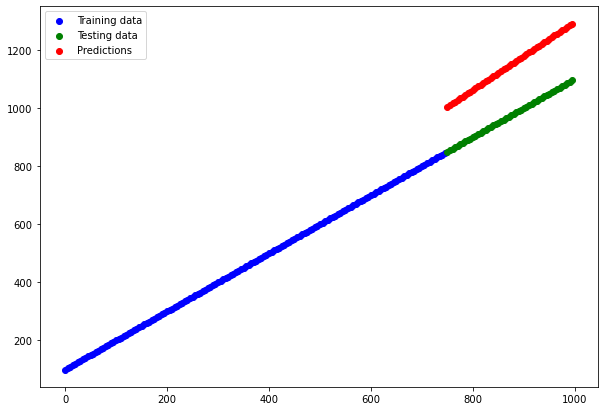

In [27]:
# Make predictions with our trained model
y_reg_preds = model_3.predict(y_reg_test)

# Plot the model's predictions against our regression data
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c='b', label='Training data')
plt.scatter(X_reg_test, y_reg_test, c='g', label='Testing data')
plt.scatter(X_reg_test, y_reg_preds.squeeze(), c='r', label='Predictions')
plt.legend();

Okay, the predictions aren't perfect (if the predictions were perfect, the red would line up with the green), but they look better than complete guessing.

So this means our model must be learning something...

There must be something we're missing out on for our classification problem.

## The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and clue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

The main change we'll add to models we've built before is the use of the `activation` keyword.


In [28]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 hidden layer with linear activation
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # note: "lr" used to be what was used, now "learning_rate" is favoured
                metrics=["accuracy"])

# Fit the model
history = model_4.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 4.2380 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 4.0223 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 3.8296 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 3.7654 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 3.6464 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 3.4960 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 3.3803 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 3.2273 - accuracy: 0.5000
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 2.8035 - accuracy: 0.5000
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 2.5701 - accuracy: 0.5000
Epoch 11/

32/32 [==============================] - 0s 1ms/step - loss: 0.7080 - accuracy: 0.4860
Epoch 83/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7075 - accuracy: 0.4880
Epoch 84/100
32/32 [==============================] - 0s 999us/step - loss: 0.7069 - accuracy: 0.4880
Epoch 85/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7064 - accuracy: 0.4860
Epoch 86/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7059 - accuracy: 0.4880
Epoch 87/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7055 - accuracy: 0.4900
Epoch 88/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7050 - accuracy: 0.4880
Epoch 89/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.4870
Epoch 90/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7042 - accuracy: 0.4890
Epoch 91/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7037 - accuracy: 0.4880
Epoch 92/10

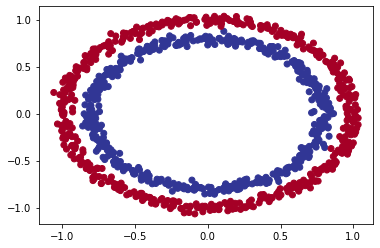

In [29]:
# check our data looks like
plt.scatter(X[:,0], X[:,1], c=y, cmap = plt.cm.RdYlBu);

doing binary classification


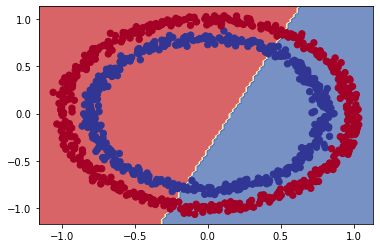

In [30]:
# Check the deicison boundary (blue is blue class, yellow is the crossover, red is red class)
plot_decision_boundary(model_4, X, y)

Well, it looks like we're getting a straight (linear) line prediction again. 

But our data is non-linear (not a straight line)...

What we're going to have to do is add some non-linearity to our model.

To do so, we'll use the `activation` parameter in on of our layers.

In [31]:
# Set random seed
tf.random.set_seed(42)

# Create a model with a non-linear activation
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.relu), # can also do activation='relu'
  tf.keras.layers.Dense(1) # output layer 
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model_5.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 2ms/step - loss: 1.8377 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 1.4449 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 1.3410 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1.2678 - accuracy: 0.4770
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 1.2116 - accuracy: 0.4390
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1664 - accuracy: 0.4180
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1294 - accuracy: 0.4250
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 1.0970 - accuracy: 0.4420
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 1.0670 - accuracy: 0.4540
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0407 - accuracy: 0.4550
Epoch 11/

32/32 [==============================] - 0s 999us/step - loss: 0.6935 - accuracy: 0.5020
Epoch 83/100
32/32 [==============================] - 0s 937us/step - loss: 0.6936 - accuracy: 0.4840
Epoch 84/100
32/32 [==============================] - 0s 937us/step - loss: 0.6932 - accuracy: 0.5070
Epoch 85/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 86/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5000
Epoch 87/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 88/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4680
Epoch 89/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.4590
Epoch 90/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.4980
Epoch 91/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4910
Epoch 9

Hmm... still not learning...

What we if increased the number of neurons and layers?

Say, 2 hidden layers, with [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu), pronounced "rel-u", (short for [rectified linear unit](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)), activation on the first one, and 4 neurons each?

To see this network in action, check out the [TensorFlow Playground demo](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).

![multi-layer neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-two-layer-net-relu-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).*

Let's try.

In [32]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, 4 neurons, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, 4 neurons, ReLU activation
  tf.keras.layers.Dense(1) # ouput layer
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001), # Adam's default learning rate is 0.001
                metrics=['accuracy'])

# Fit the model
history = model_6.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11/

32/32 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 83/100
32/32 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 84/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 85/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 86/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 87/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 88/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 89/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 90/100
32/32 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 91/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 92/100


In [33]:
# Evaluate the model
model_6.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.5000


[7.712474346160889, 0.5]

We're still hitting 50% accuracy, our model is still practically as good as guessing.

How do the predictions look?

doing binary classification


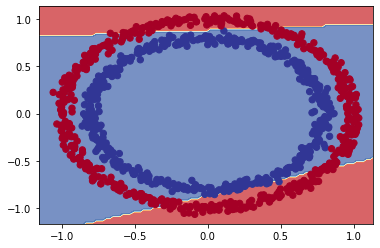

In [34]:
# Check out the predictions using 2 hidden layers
plot_decision_boundary(model_6, X, y)

What gives? 

It seems like our model is the same as the one in the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true) but model it's still drawing straight lines... 

Ideally, the yellow lines go on the inside of the red circle and the blue circle.

Okay, okay, let's model this circle once and for all. 

One more model (I promise... actually, I'm going to have to break that promise... we'll be building plenty more models). 

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the [Sigmoid activation function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid).

In [35]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history = model_7.fit(X, y, epochs=100, verbose=0)

In [36]:
# Evaluate our model
model_7.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.2948 - accuracy: 0.9910


[0.29480037093162537, 0.9909999966621399]

doing binary classification


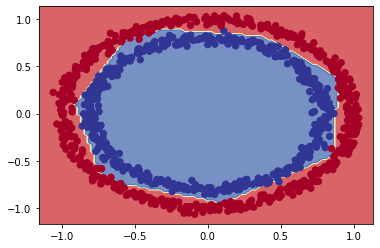

In [37]:
# View the predictions of the model with relu and sigmoid activations
plot_decision_boundary(model_7, X, y)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [38]:
# Create a toy tensor (similar to the data we pass into our model)
A = tf.cast(tf.range(-10,10), dtype=tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

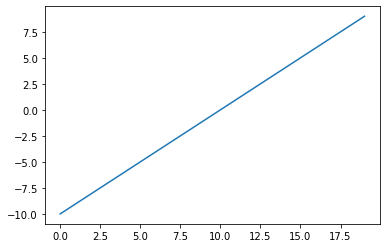

In [39]:
plt.plot(A)

A straight (linear) line!

Nice, now let's recreate the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) and see what it does to our data. You can also find a pre-built sigmoid function at [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).

In [40]:
# Sigmoid - https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
# f(z) = 1/ 1+e^-z
def sigmoid(z):
    return 1 / (1 + tf.exp(-z))

# Use the sigmoid function on our tensor
sigmoid(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397872e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726230e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105860e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

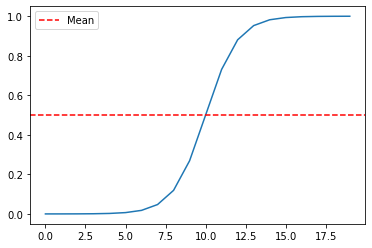

In [41]:
# Plot sigmoid modified tensor
plt.plot(sigmoid(A))
plt.axhline(0.5, color = 'r', label='Mean', linestyle='--')
plt.legend()

A non-straight (non-linear) line!

Okay, how about the [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.) (ReLU turns all negatives to 0 and positive numbers stay the same)?

In [42]:
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

In [43]:
def relu(x):
    return tf.maximum(0, x)

relu(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

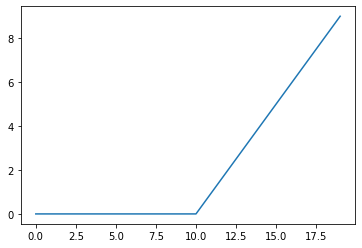

In [44]:
# Plot ReLU-modified tensor
plt.plot(relu(A));

Another non-straight line!

Well, how about TensorFlow's [linear activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear)? 

In [45]:
# Lets try linear activation fun
tf.keras.activations.linear(A) # returns the same input give to it

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

In [46]:
# Does the linear activation change anything?
A == tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

Okay, so it makes sense now the model doesn't really learn anything when using only linear activation functions, because the linear activation function doesn't change our input data in anyway.

Where as, with our non-linear functions, our data gets manipulated. A neural network uses these kind of transformations at a large scale to figure draw patterns between its inputs and outputs.

Now rather than dive into the guts of neural networks, we're going to keep coding applying what we've learned to different problems but if you want a more in-depth look at what's going on behind the scenes, check out the Extra Curriculum section below. 

> 📖  **Resource:** For more on activation functions, check out the [machine learning cheatsheet page](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#) on them.

## Evaluating and improving our classification model

If you answered the question above, you might've picked up what we've been doing wrong.

We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

Let's do it.

In [47]:
# How many examples are in the whole dataset?
len(X)

1000

In [48]:
# Split data into train and test sets
X_train, y_train = X[:800], y[:800] # 80% of the data for the training set
X_test, y_test = X[800:], y[800:] # 20% of the data for the test set

# Check the shapes of the data
X_train.shape, X_test.shape # 800 examples in the training set, 200 examples in the test set 

((800, 2), (200, 2))

Great, now we've got training and test sets, let's model the training data and evaluate what our model has learned on the test set.

In [49]:
# set seed
tf.random.set_seed(42)

# Build a model
model_8 = tf.keras.Sequential([
  
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile a model
model_8.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(lr=0.01),
               metrics = ['accuracy'])

# Fit the model
history = model_8.fit(X_train, y_train, epochs=25)

Epoch 1/25
25/25 [==============================] - 0s 1ms/step - loss: 0.6847 - accuracy: 0.5425
Epoch 2/25
25/25 [==============================] - 0s 1ms/step - loss: 0.6777 - accuracy: 0.5525
Epoch 3/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6736 - accuracy: 0.5512
Epoch 4/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6681 - accuracy: 0.5775
Epoch 5/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6633 - accuracy: 0.5850
Epoch 6/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.5838
Epoch 7/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.6750
Epoch 8/25
25/25 [==============================] - 0s 1ms/step - loss: 0.6264 - accuracy: 0.7013
Epoch 9/25
25/25 [==============================] - 0s 1ms/step - loss: 0.6038 - accuracy: 0.7487
Epoch 10/25
25/25 [==============================] - 0s 1ms/step - loss: 0.5714 - accuracy: 0.7738
Epoch 11/25
25/25 [

In [50]:
# Evaluate our model on the test set
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 [==============================] - 0s 2ms/step - loss: 0.1247 - accuracy: 1.0000
Model loss on the test set: 0.12468849122524261
Model accuracy on the test set: 100.00%


100% accuracy? Nice!

Now, when we started to create `model_8` we said it was going to be the same as `model_7` but you might've found that to be a little lie.

That's because we changed a few things: 
* **The `activation` parameter** - We used strings (`"relu"` & `"sigmoid"`) instead of using library paths (`tf.keras.activations.relu`), in TensorFlow, they both offer the same functionality.
* **The `learning_rate` (also `lr`) parameter** - We increased the **learning rate** parameter in the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) to `0.01` instead of `0.001` (an increase of 10x).
  * You can think of the learning rate as how quickly a model learns. The higher the learning rate, the faster the model's capacity to learn, however, there's such a thing as a *too high* learning rate, where a model tries to learn too fast and doesn't learn anything. We'll see a trick to find the ideal learning rate soon.
* **The number of epochs** - We lowered the number of epochs (using the `epochs` parameter) from 100 to 25 but our model still got an incredible result on both the training and test sets.
  * One of the reasons our model performed well in even less epochs (remember a single epoch is the model trying to learn patterns in the data by looking at it once, so 25 epochs means the model gets 25 chances) than before is because we increased the learning rate.

We know our model is performing well based on the evaluation metrics but let's see how it performs visually.


doing binary classification
doing binary classification


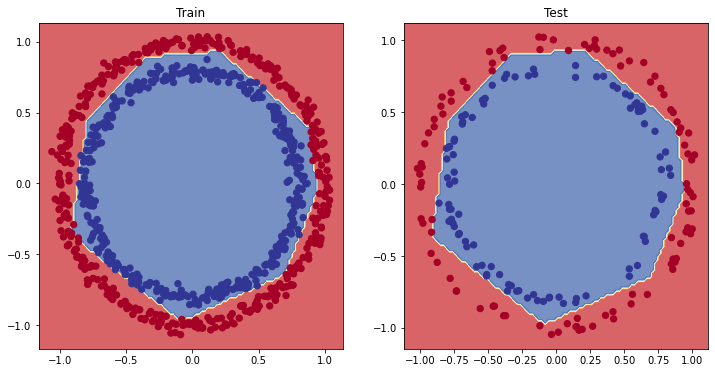

In [51]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X=X_test, y=y_test)
plt.show()

### Plot the loss curves

Looking at the plots above, we can see the outputs of our model are very good.

But how did our model go whilst it was learning?

As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

To figure this out, we can check the **loss curves** (also referred to as the **learning curves**).

You might've seen we've been using the variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

This is where we'll get the information for how our model is performing as it learns.

Let's see how we might use it.

In [52]:
# You can access the information in the history variable using the .history attribute
pd.DataFrame(history.history)

,loss,accuracy
0,0.684651,0.54250
1,0.677721,0.55250
2,0.673595,0.55125
3,0.668149,0.57750
4,0.663269,0.58500
5,0.654567,0.58375
6,0.641258,0.67500
7,0.626428,0.70125
8,0.603831,0.74875
9,0.571404,0.77375


Inspecting the outputs, we can see the loss values going down and the accuracy going up. 

How's it look (visualize, visualize, visualize)?

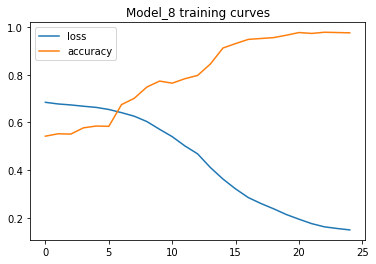

In [53]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_8 training curves");

Beautiful. This is the ideal plot we'd be looking for when dealing with a classification problem, loss going down, accuracy going up.

> 🔑 **Note:** For many problems, the loss function going down means the model is improving (the predictions it's making are getting closer to the ground truth labels).

### Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the most important hyperparameter you can tune for your neural network models is the **learning rate**.

In `model_8` you saw we lowered the Adam optimizer's learning rate from the default of `0.001` (default) to `0.01`.

And you might be wondering why we did this.

Put it this way, it was a lucky guess.

I just decided to try a lower learning rate and see how the model went.

Now you might be thinking, "Seriously? You can do that?"

And the answer is yes. You can change any of the hyperparamaters of your neural networks.

With practice, you'll start to see what kind of hyperparameters work and what don't.

That's an important thing to understand about machine learning and deep learning in general. It's very experimental. You build a model and evaluate it, build a model and evaluate it.

That being said, I want to introduce you a trick which will help you find the optimal learning rate (at least to begin training with) for your models going forward.

To do so, we're going to use the following:
* A [learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
   * You can think of a callback as an extra piece of functionality you can add to your model *while* its training.
* Another model (we could use the same ones as above, we we're practicing building models here).
* A modified loss curves plot.

We'll go through each with code, then explain what's going on.

> 🔑 **Note:** The default hyperparameters of many neural network building blocks in TensorFlow are setup in a way which usually work right out of the box (e.g. the [Adam optimizer's](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) default settings can usually get good results on many datasets). So it's a good idea to try the defaults first, then adjust as needed.

>🔑**Note : - what does 1e-4 or 1e4 means ?**<br>
That notation is a convenience for writing and comparing very large, or in this case very small numbers.<br>

>whereby you give the first non-zero digit, then tell which decimal place it falls in. So 3,120,000 has six digits after the initial “3” and can be written 3e6, or better yet, without rounding all those other valuable digits, 3.12e6. Your number, 1e-4, means the 1 is four digits the other way, so 1e-4 = 0.0001. <br>

>To be completely accurate, the e-4 means multiply by 10^-4 or 1/10^4 or .ooo1. In fact it is because the -4 is an exponent on base 10 that the letter e was chosen. Two more examples: 5e3 = 5 x 10^3 = 5000 with three digits after the 5 (the decimal point went over 3 spaces) and 3.86e-5 = 3.86 x 10^-5 = 0.0000386 with the 3 in the fifth decimal place (decimal point went over 5 spaces).

In [54]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as model_8)
model_9 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_9.compile(loss="binary_crossentropy", # we can use strings here too
              optimizer="Adam", # same as tf.keras.optimizers.Adam() with default settings
              metrics=["accuracy"]) 

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20), # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch
                                                        verbose=1) 

# Fit the model (passing the lr_scheduler callback)
history = model_9.fit(X_train, 
                      y_train, 
                      epochs=100,
                      callbacks=[lr_scheduler],
                      use_multiprocessing=True)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/100
25/25 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.4988

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00011220184543019634.
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.4975

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00012589254117941674.
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.4963

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00014125375446227543.
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.4975

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00015848931924611136.
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5063

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0001778279410038923.
Epoch 

25/25 [==============================] - 0s 919us/step - loss: 0.3455 - accuracy: 0.9112

Epoch 00046: LearningRateScheduler reducing learning rate to 0.01778279410038923.
Epoch 46/100
25/25 [==============================] - 0s 919us/step - loss: 0.2570 - accuracy: 0.9463

Epoch 00047: LearningRateScheduler reducing learning rate to 0.01995262314968879.
Epoch 47/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1968 - accuracy: 0.9575

Epoch 00048: LearningRateScheduler reducing learning rate to 0.022387211385683402.
Epoch 48/100
25/25 [==============================] - 0s 959us/step - loss: 0.1336 - accuracy: 0.9700

Epoch 00049: LearningRateScheduler reducing learning rate to 0.025118864315095798.
Epoch 49/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.9613

Epoch 00050: LearningRateScheduler reducing learning rate to 0.02818382931264455.
Epoch 50/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1002 - accurac

25/25 [==============================] - 0s 879us/step - loss: 0.7818 - accuracy: 0.4913

Epoch 00091: LearningRateScheduler reducing learning rate to 3.1622776601683795.
Epoch 91/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7918 - accuracy: 0.5163

Epoch 00092: LearningRateScheduler reducing learning rate to 3.5481338923357533.
Epoch 92/100
25/25 [==============================] - 0s 959us/step - loss: 0.7423 - accuracy: 0.5113

Epoch 00093: LearningRateScheduler reducing learning rate to 3.981071705534969.
Epoch 93/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7372 - accuracy: 0.5088

Epoch 00094: LearningRateScheduler reducing learning rate to 4.4668359215096345.
Epoch 94/100
25/25 [==============================] - 0s 959us/step - loss: 0.7560 - accuracy: 0.4938

Epoch 00095: LearningRateScheduler reducing learning rate to 5.0118723362727255.
Epoch 95/100
25/25 [==============================] - 0s 1ms/step - loss: 0.8126 - accuracy: 0.486

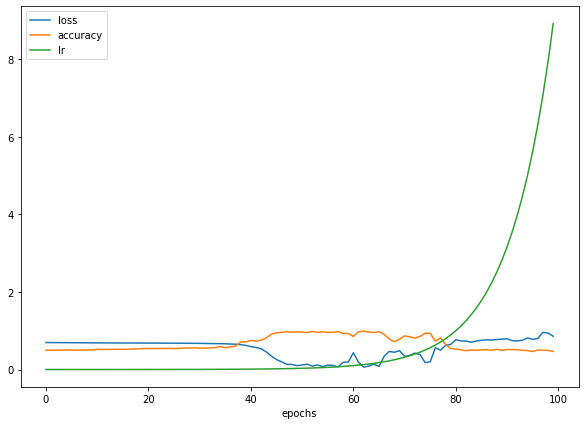

In [55]:
# Checkout the history
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

As you you see the learning rate exponentially increases as the number of epochs increases.

And you can see the model's accuracy goes up (and loss goes down) at a specific point when the learning rate slowly increases.

To figure out where this infliction point is, we can plot the loss versus the log-scale learning rate.

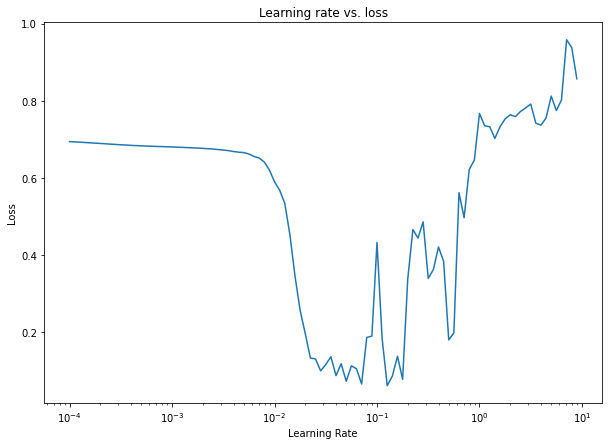

In [56]:
# Plot the learning rate versus the loss
lrs = 1e-4 * 10**(np.arange(100)/20)

plt.figure(figsize=(10,7))

plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

To figure out the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`.

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (a value where the loss is still decreasing).*

In [57]:
# Example of other typical learning rate values
10**0, 10**-1, 10**-2, 10**-3, 1e-4

(1, 0.1, 0.01, 0.001, 0.0001)

Now we've estimated the ideal learning rate (we'll use `0.02`) for our model, let's refit it.

In [58]:
# Set seed
tf.random.set_seed(42)

# build model
model_10 = tf.keras.Sequential([
    
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile a model
model_10.compile(loss = 'binary_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(lr = 0.02),
                 metrics = ['accuracy'])

# Fit the model for 20 epochs (5 less than before)
history = model_10.fit(X_train, y_train, epochs=20)

Epoch 1/20
25/25 [==============================] - 1s 52ms/step - loss: 0.6837 - accuracy: 0.5600
Epoch 2/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5750
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6626 - accuracy: 0.5875
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6332 - accuracy: 0.6388
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 0.5830 - accuracy: 0.7563
Epoch 6/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4907 - accuracy: 0.8313
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4251 - accuracy: 0.8450
Epoch 8/20
25/25 [==============================] - 0s 2ms/step - loss: 0.3596 - accuracy: 0.8875
Epoch 9/20
25/25 [==============================] - 0s 1ms/step - loss: 0.3152 - accuracy: 0.9100
Epoch 10/20
25/25 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.9500
Epoch 11/20
25/25 

Nice! With a little higher learning rate (`0.02` instead of `0.01`) we reach a higher accuracy than `model_8` in less epochs (`20` instead of `25`).

> 🛠 **Practice:** Now you've seen an example of what can happen when you change the learning rate, try changing the learning rate value in the [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.03154&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&problem_hide=true) and see what happens. What happens if you increase it? What happens if you decrease it?



In [62]:
# Evaluate model on the test dataset
model_10.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.0574 - accuracy: 0.9900


[0.05740182474255562, 0.9900000095367432]

Let's see model predictions

doing binary classification
doing binary classification


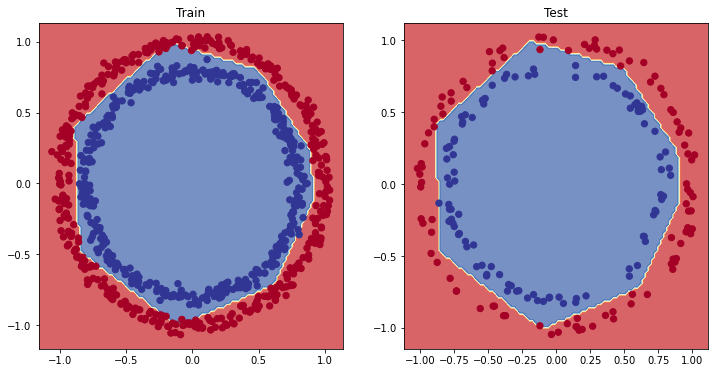

In [66]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_10, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_10, X=X_test, y=y_test)
plt.show()

And as we can see, almost perfect again.

These are the kind of experiments you'll be running often when building your own models.

Start with default settings and see how they perform on your data.

And if they don't perform as well as you'd like, improve them.

Let's look at a few more ways to evaluate our classification models.

### More classification evaluation methods

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

> 🔑 **Note:** Every classification problem will require different kinds of evaluation methods. But you should be familiar with at least the ones above.

Let's start with accuracy.

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.

In [67]:
# Check the accuracy of our model
loss, accuracy = model_10.evaluate(X_test, y_test)
print(f"model loss on test set {loss}")
print(f"model accuracy on test set {(accuracy*100):.2f}")

7/7 [==============================] - 0s 1ms/step - loss: 0.0574 - accuracy: 0.9900
model loss on test set 0.05740182474255562
model accuracy on test set 99.00


How about a confusion matrix?

![anatomy of a confusion matrix](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-anatomy-of-a-confusion-matrix.png)
*Anatomy of a confusion matrix (what we're going to be creating). Correct predictions appear down the diagonal (from top left to bottom right).*

We can make a confusion matrix using [Scikit-Learn's `confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method.

In [72]:
from sklearn.metrics import confusion_matrix

# create a confusion matrix
y_preds = model_10.predict(X_test)

# plot confusion matrix
confusion_matrix(y_test, y_preds)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

Ahh, it seems our predictions aren't in the format they need to be.

Let's check them out.

In [73]:
y_test[:10]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [74]:
y_preds[:10]

array([[9.8526543e-01],
       [9.9923784e-01],
       [9.9032342e-01],
       [9.9706948e-01],
       [3.9622927e-01],
       [1.8126875e-02],
       [9.6829063e-01],
       [1.9746691e-02],
       [9.9967170e-01],
       [5.6457520e-04]], dtype=float32)

It looks like we need to get our predictions into the binary format (0 or 1).

But you might be wondering, what format are they currently in?

In their current format (`9.8526537e-01`), they're in a form called **prediction probabilities**.

You'll see this often with the outputs of neural networks. Often they won't be exact values but more a probability of how *likely* they are to be one value or another.

So one of the steps you'll often see after making predicitons with a neural network is converting the prediction probabilities into labels.

In our case, since our ground truth labels (`y_test`) are binary (0 or 1), we can convert the prediction probabilities using to their binary form using [`tf.round()`](https://www.tensorflow.org/api_docs/python/tf/math/round).

In [75]:
# Convert prediction probabilities to binary format and view the first 10
tf.round(y_preds)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [76]:
# Create a confusion matrix
confusion_matrix(y_test, tf.round(y_preds))

array([[99,  2],
       [ 0, 99]], dtype=int64)

Alright, we can see the highest numbers are down the diagonal (from top left to bottom right) so this a good sign, but the rest of the matrix doesn't really tell us much.

How about we make a function to make our confusion matrix a little more visual?

In [80]:
cm = confusion_matrix(y_test, tf.round(y_preds))
cm.sum(axis=1)[:,np.newaxis]

array([[101],
       [ 99]], dtype=int64)

In [83]:
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]# normalize the matrix
cm_norm

array([[0.98019802, 0.01980198],
       [0.        , 1.        ]])

In [91]:
for i, j in itertools.product([0,1], [2,3]):
    print(i, j)

0 2
0 3
1 2
1 3


In [90]:
range(cm.shape[0]), cm.shape[0], cm.shape[1]

(range(0, 2), 2, 2)

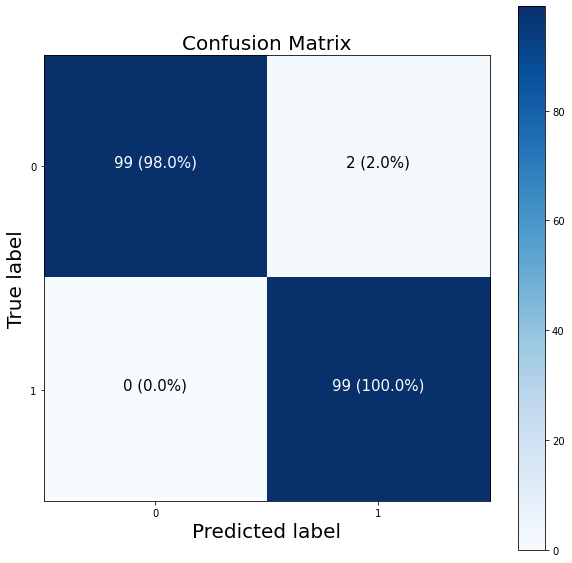

In [86]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
import itertools

figsize=(10,10)

# Create a confusion matrix
cm = confusion_matrix(y_test, tf.round(y_preds))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the matrix
n_classes = cm.shape[0]

# Let's pretifiy the matrix
fig, ax = plt.subplots(figsize = figsize)

# create a matrix plot
cax = ax.matshow(cm, cmap = plt.cm.Blues)
fig.colorbar(cax)

# create classes
classes = False

if classes:
    labels = classes
else:
    labels = np.arange(cm.shape[0])
    
# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text in each cell suing coordinates i ,j
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
             horizontalalignment = "center",
             color = "white" if cm[i, j] > threshold else "black",
             size = 15)

In [87]:
# What does itertools.product do? Combines two things into each combination
import itertools
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    print(i, j)

0 0
0 1
1 0
1 1


## Working with a larger example (multiclass classification)

We've seen a binary classification example (predicting if a data point is part of a red circle or blue circle) but what if you had multiple different classes of things?

For example, say you were a fashion company and you wanted to build a neural network to predict whether a piece of clothing was a shoe, a shirt or a jacket (3 different options).

When you have more than two classes as an option, this is known as **multiclass classification**.

The good news is, the things we've learned so far (with a few tweaks) can be applied to multiclass classification problems as well.

Let's see it in action.

To start, we'll need some data. The good thing for us is TensorFlow has a multiclass classication dataset known as [Fashion MNIST built-in](https://github.com/zalandoresearch/fashion-mnist). Meaning we can get started straight away.

We can import it using the [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) module.

> 📖 **Resource:** The following multiclass classification problem has been adapted from the [TensorFlow classification guide](https://www.tensorflow.org/tutorials/keras/classification). A good exercise would be to once you've gone through the following example, replicate the TensorFlow guide.

In [92]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# The data is already been sorted in training and test set
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 3s 1us/step


In [93]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n") 
print(f"Training label: {train_labels[0]}")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

In [94]:
# check the shape of 1st example
train_data[0].shape, train_labels[0].shape

((28, 28), ())

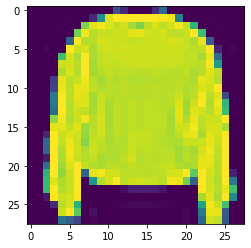

In [96]:
# plot a single sample
import matplotlib.pyplot as plt
plt.imshow(train_data[7])

In [97]:
# check the label
train_labels[7] # pull-over

2

It looks like our labels are in numerical form. And while this is fine for a neural network, you might want to have them in human readable form.

Let's create a small list of the class names (we can find them on [the dataset's GitHub page](https://github.com/zalandoresearch/fashion-mnist#labels)).

> 🔑 **Note:** Whilst this dataset has been prepared for us and ready to go, it's important to remember many datasets won't be ready to go like this one. Often you'll have to do a few preprocessing steps to have it ready to use with a neural network (we'll see more of this when we work with our own data later).

In [98]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# How many classes are there (this'll be our output shape)?
len(class_names)

10

Now we have these, let's plot another example.

> 🤔 **Question:** Pay particular attention to what the data we're working with *looks* like. Is it only straight lines? Or does it have non-straight lines as well? Do you think if we wanted to find patterns in the photos of clothes (which are actually collections of pixels), will our model need non-linearities (non-straight lines) or not?

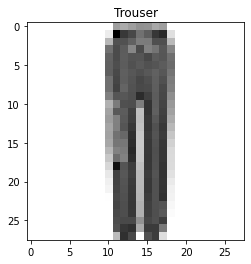

In [103]:
# plot an example image and its label
plt.imshow(train_data[1000], cmap = plt.cm.binary) #to chnage the image to grey (British english)
plt.title(class_names[train_labels[1000]]);

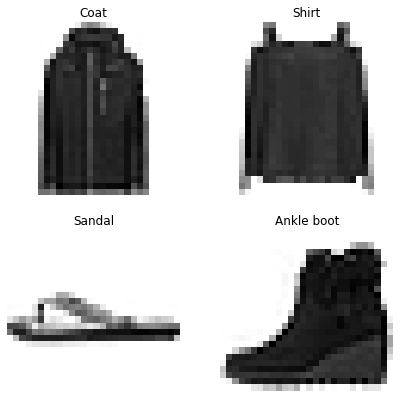

In [107]:
# Plot multiple random images of fashion MNIST
import random

plt.figure(figsize=(7,7))

for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    
    random_index = random.choice(range(len(train_data)))
    
    plt.imshow(train_data[random_index], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[random_index]]);
#     plt.xticks([])
#     plt.yticks([])
    plt.axis(False) # work same as abole two lines

Alright, let's build a model to figure out the relationship between the pixel values and their labels.

Since this is a multiclass classification problem, we'll need to make a few changes to our architecture (inline with Table 1 above):

* The **input shape** will have to deal with 28x28 tensors (the height and width of our images).
  * We're actually going to squash the input into a tensor (vector) of shape `(784)`.
* The **output shape** will have to be 10 because we need our model to predict for 10 different classes.
  * We'll also change the `activation` parameter of our output layer to be [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) instead of `'sigmoid'`. As we'll see the `"softmax"` activation function outputs a series of values between 0 & 1 (the same shape as **output shape**, which together add up to ~1. The index with the highest value is predicted by the model to be the most *likely* class.
* We'll need to change our loss function from a binary loss function to a multiclass loss function. 
  * More specifically, since our labels are in integer form, we'll use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), if our labels were one-hot encoded (e.g. they looked something like `[0, 0, 1, 0, 0...]`), we'd use [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).
* We'll also use the `validation_data` parameter when calling the `fit()` function. This will give us an idea of how the model performs on the test set during training.

You ready? Let's go.

In [ ]:
# lecture 26 2:27